In [95]:
import pandas as pd 
import os
os.chdir("/home/robbe/ionbot")
import OxiAnalysis as OA
os.chdir("/home/robbe/ionbot/Ageing_study/")
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt

In [96]:
quant = pd.read_csv("Ageing_combined.csv", index_col=[0])

In [97]:
SI = OA.summedintensities(quant)

In [98]:
SI

,Modifications,Gene Names,Organism,Intensity_150828_PC_VUR_C1077,Intensity_150828_PC_VUR_C1133,Intensity_150828_PC_VUR_C1134,Intensity_150828_PC_VUR_C1138,Intensity_150828_PC_VUR_C1189,Intensity_150828_PC_VUR_C1205,Intensity_150828_PC_VUR_C1256,...,Intensity_1DLC012615QE_RRAG_014B_rep1,Intensity_1DLC012615QE_RRAG_014B_rep2,Intensity_1DLC051815QE_RRAG_011B_rep1,Intensity_1DLC051815QE_RRAG_011B_rep2,Intensity_1DLC051815QE_RRAG_028B_rep1,Intensity_1DLC051815QE_RRAG_028B_rep2,Intensity_1DLC052815QE_RRAG_024B_rep1,Intensity_1DLC052815QE_RRAG_024B_rep2,Intensity_1DLC052815QE_RRAG_025B_rep1,Oxmod?
0,[1384]Homocysteic_acid[M],0.0,0.0,0.000000,0.000000,0.000000,0.000071,0.000000,0.000058,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,35
1,[1914]Met->AspSA[M],0.0,0.0,0.000000,0.000000,0.000139,0.000075,0.000076,0.000070,0.000142,...,0.000000,0.000000,0.0,0.000089,0.000000,0.000093,0.000000,0.0001,0.000101,66
2,[1915]Decarboxylation[D],0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000040,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000085,0.000000,0.000000,0.0000,0.000086,27
3,[1915]Decarboxylation[E],0.0,0.0,0.000090,0.000000,0.000000,0.000000,0.000134,0.000039,0.000080,...,0.000000,0.000000,0.0,0.000000,0.000122,0.000000,0.000000,0.0000,0.000000,52
4,[1916]Aspartylurea[H],0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000068,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,[743]4-ONE+Delta:H(-2)O(-1)[H],0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,2
83,[860]G-H1[R],0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,7
84,[936]Chlorination[Y],0.0,0.0,0.000096,0.000075,0.000000,0.000132,0.000096,0.000091,0.000117,...,0.000141,0.000124,0.0,0.000150,0.000000,0.000000,0.000000,0.0000,0.000000,54
85,[937]dichlorination[Y],0.0,0.0,0.000000,0.000095,0.000000,0.000068,0.000049,0.000056,0.000084,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,14


In [99]:
Young = SI.filter(regex="Modifications|Protein Groups|PC_VUR")
Old = SI.filter(regex="Modifications|Protein Groups|RRAG")

In [100]:
dict = {}
patientIDlist = []
patientIDBlist = []
for i in [6,11,14,24,25,28]:
    patientID = "_"+str(i).zfill(3)+"_"
    patientIDB = "_"+str(i).zfill(3)+"B_"
    patientIDlist.append(patientID)
    patientIDBlist.append(patientIDB)
for patient in patientIDlist:
    selected = Old[[col for col in Old if patient in col]]
    selected["Modifications"] = Old["Modifications"]
    dict[patient] = selected
for patientB in patientIDBlist:
    selectedB = Old[[col for col in Old if patientB in col]]
    selected["Modifications"] = Old["Modifications"]
    dict[patientB] = selectedB

In [101]:
for i in dict:
    df = dict[i]
    df["median"] = df.median(axis=1)

In [102]:
df

,Intensity_1DLC051815QE_RRAG_028B_rep1,Intensity_1DLC051815QE_RRAG_028B_rep2,median
0,0.000000,0.000000,0.000000
1,0.000000,0.000093,0.000047
2,0.000085,0.000000,0.000043
3,0.000122,0.000000,0.000061
4,0.000000,0.000000,0.000000
...,...,...,...
82,0.000000,0.000000,0.000000
83,0.000000,0.000000,0.000000
84,0.000000,0.000000,0.000000
85,0.000000,0.000000,0.000000


In [103]:
Oldrep = pd.DataFrame()
Oldrep["Modifications"] = Old["Modifications"]
for patient in dict:
    Oldrep[patient] = dict[patient]["median"]

In [104]:
Oldrep

,Modifications,_006_,_011_,_014_,_024_,_025_,_028_,_006B_,_011B_,_014B_,_024B_,_025B_,_028B_
0,[1384]Homocysteic_acid[M],0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,[1914]Met->AspSA[M],0.000000,0.000000,0.000000,0.000000,0.000074,0.000000,0.000000,0.000044,0.000000,0.000050,0.000101,0.000047
2,[1915]Decarboxylation[D],0.000044,0.000042,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000086,0.000043
3,[1915]Decarboxylation[E],0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000061
4,[1916]Aspartylurea[H],0.000000,0.000053,0.000000,0.000024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,[743]4-ONE+Delta:H(-2)O(-1)[H],0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
83,[860]G-H1[R],0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
84,[936]Chlorination[Y],0.000186,0.000186,0.000123,0.000058,0.000067,0.000113,0.000130,0.000075,0.000132,0.000000,0.000000,0.000000
85,[937]dichlorination[Y],0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Boxplot

In [113]:
def boxplots(Controldf, Treatmentdf, specific=True):
    import scipy.stats as stats
    from statsmodels.stats.multitest import multipletests
    from pyteomics import mass as pymass
    from itertools import combinations
    import re
    from statannotations.Annotator import Annotator
    db = pymass.Unimod()

    pvallist = []
    for index, row in Controldf.iterrows():
        for index2, row2 in Treatmentdf.iterrows():
            if index == index2:
                if specific:
                    mod = row["Modifications"]
                    modname = re.search(pattern=r"\[\d+\](.*)", string=mod).group(1)
                else:
                    mod = row["UnimodAccession"]
                    modname = mod
                dataControl = Controldf.iloc[index][1:]
                dataControl = dataControl.astype(float)
                dataControl = dataControl.astype(float)
                dataControl = dataControl[dataControl != 0]
                dataTreatment = Treatmentdf.iloc[index][1:]
                dataTreatment = dataTreatment.astype(float)
                dataTreatment = dataTreatment[dataTreatment !=0]
                if dataTreatment.size != 0 and dataControl.size != 0:
                    pval = stats.mannwhitneyu(dataControl, dataTreatment).pvalue
                    pvallist.append(pval)
                    if (pval < 0.05):
                        plt.figure(figsize=(8,8))
                        df = pd.DataFrame({"Young": pd.Series(dataControl.values), "Old": pd.Series(dataTreatment.values)})
                        
                        ax = sns.boxplot(data=df)
                        pairs = list(combinations(["Young", "Old"], r=2))
                        annotator = Annotator(ax, pairs = pairs, data=df)
                        annotator.configure(test="Mann-Whitney", verbose=0, text_format="simple")
                        annotator.apply_and_annotate()
                        sns.stripplot(data=df, alpha = 0.7, color="black")
                        plt.title("{}-modified peptide intensities".format(modname))
                        plt.ylabel("summed log2(peptide intensities)")
                        plt.show()
    corrected_pvals = multipletests(pvallist, method= "fdr_bh")[1].tolist()
    counter = 0
    for i in zip(pvallist, corrected_pvals):
        if i[0] < 0.05:
            print("{}: {} => {}".format(counter, i[0], i[1]))
            counter += 1
            


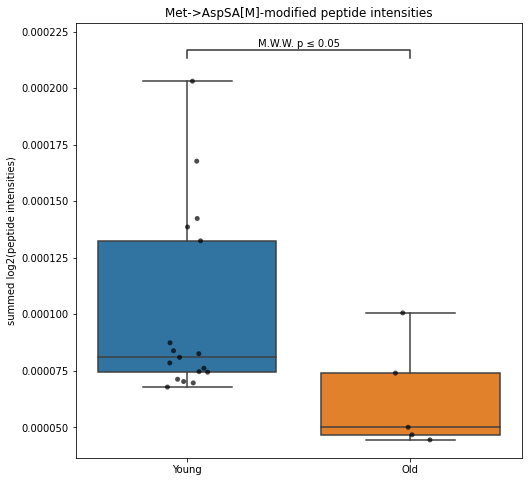

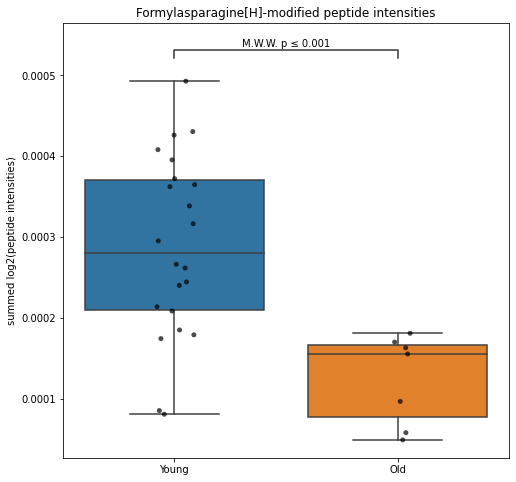

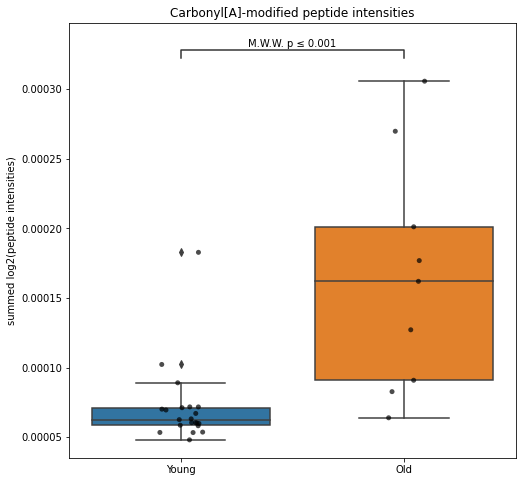

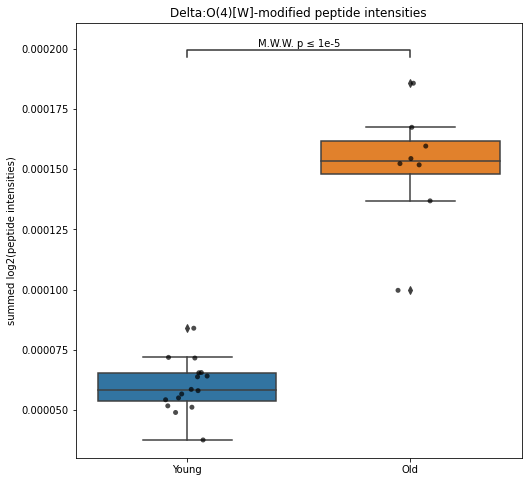

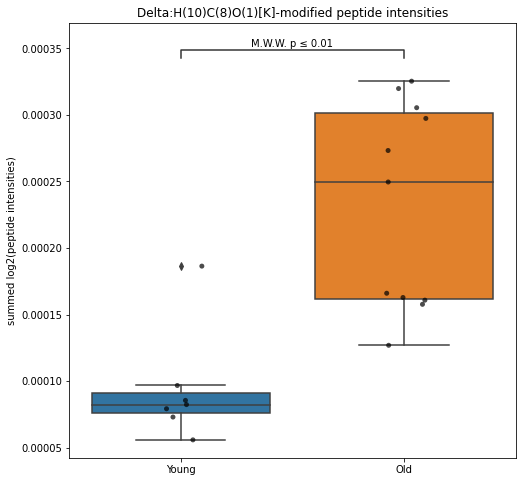

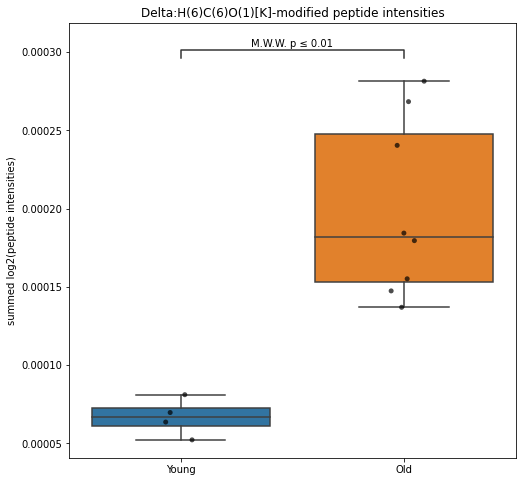

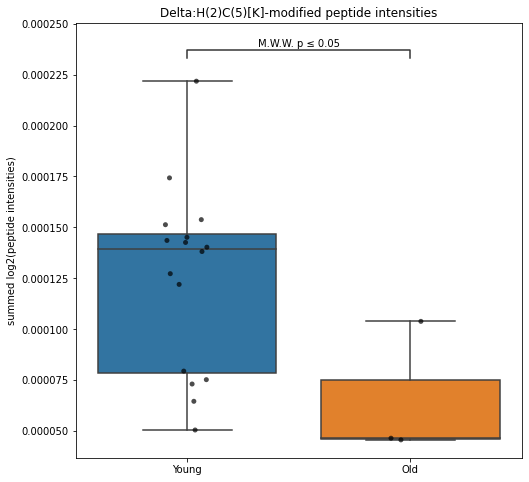

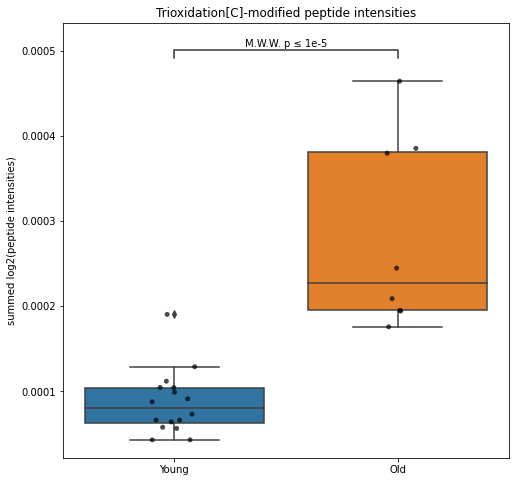

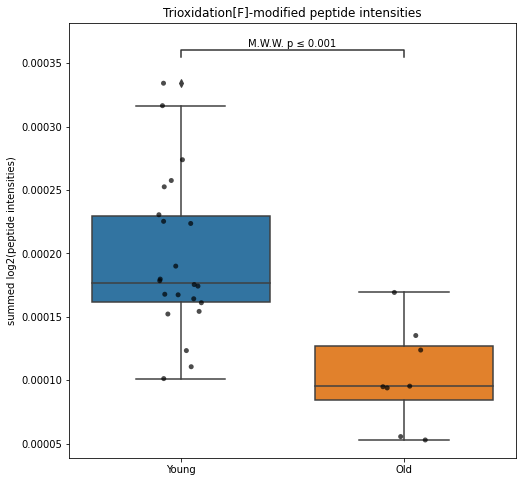

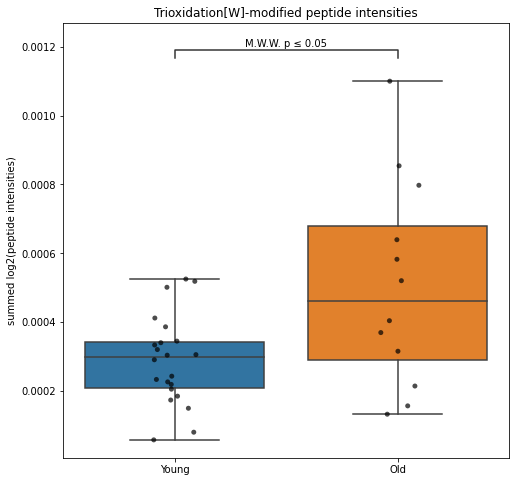

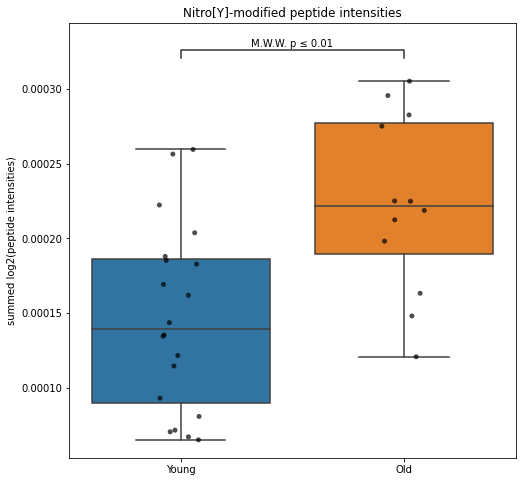

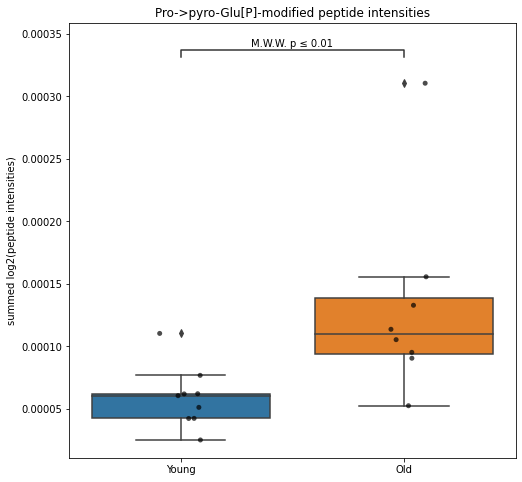

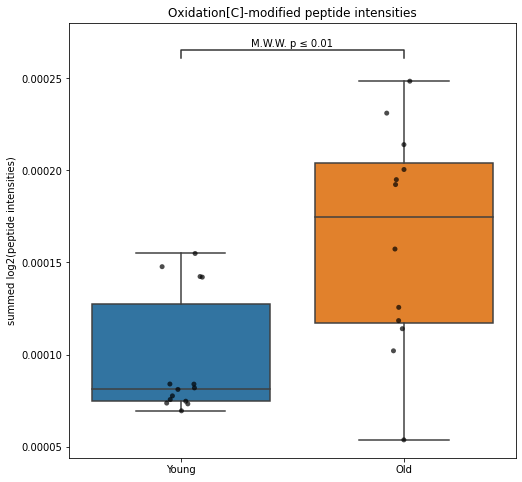

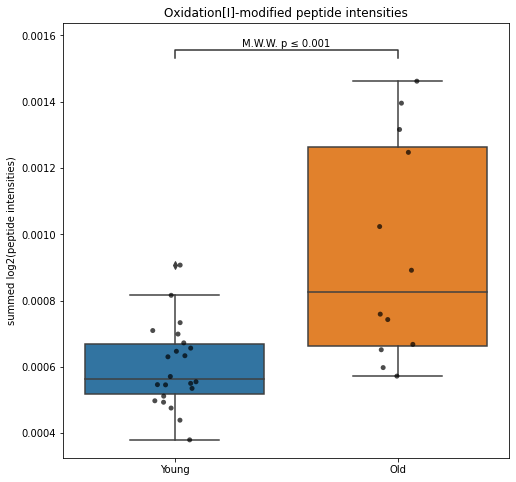

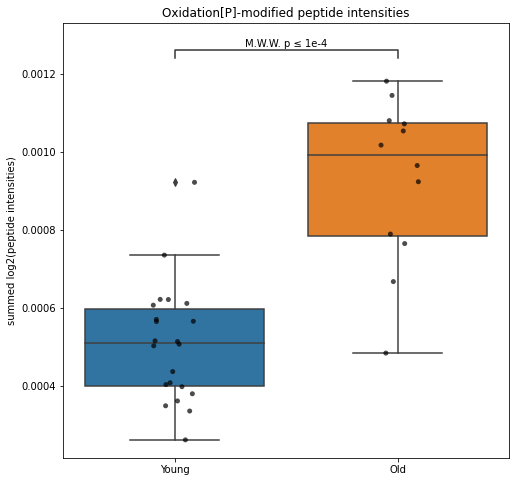

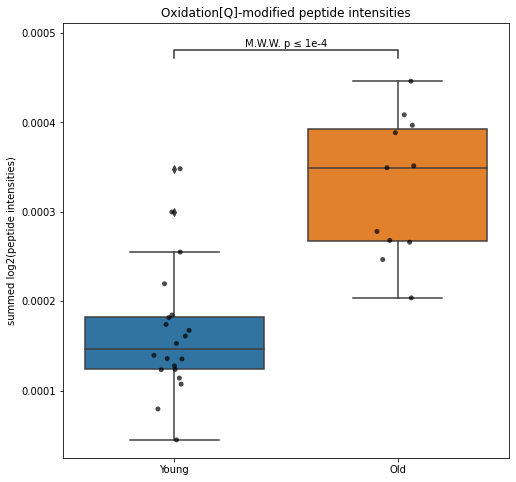

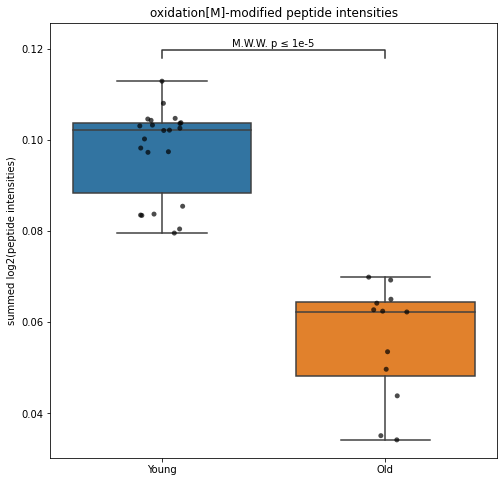

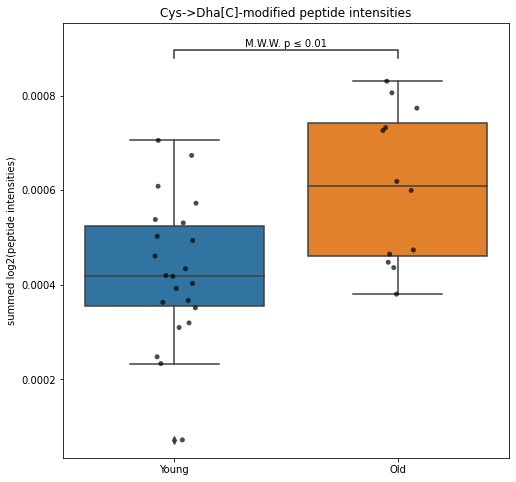

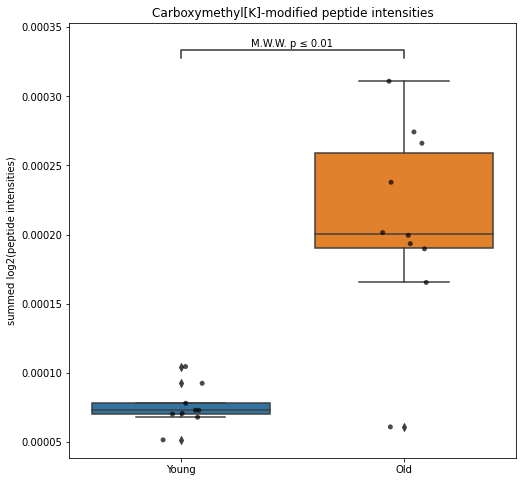

0: 0.03865724918356497 => 0.1261447078621594
1: 0.0003152270018836735 => 0.0027920105881125367
2: 0.0004926270009862024 => 0.0038178592576430686
3: 2.719345834166133e-06 => 8.429972085915012e-05
4: 0.0011940673705379587 => 0.007403217697335344
5: 0.00404040404040404 => 0.01926961926961927
6: 0.033023735810113516 => 0.12043950707217872
7: 5.438691668332266e-06 => 0.00011239962781220015
8: 0.00020810107766629506 => 0.002150377802551716
9: 0.038250879960103464 => 0.1261447078621594
10: 0.003294499897095937 => 0.01702158280166234
11: 0.005512134923899629 => 0.022783491018785133
12: 0.005927900834100707 => 0.02297061573214024
13: 0.0007530302153165608 => 0.0051875414832918635
14: 3.6865659808498135e-05 => 0.0005714177270317211
15: 6.773274595142255e-05 => 0.0008398860497976396
16: 2.148485851840218e-06 => 8.429972085915012e-05
17: 0.004670192363741602 => 0.020682280467998523
18: 0.0028804846690270907 => 0.016235459043607237


In [106]:
boxplots(Young, Oldrep)

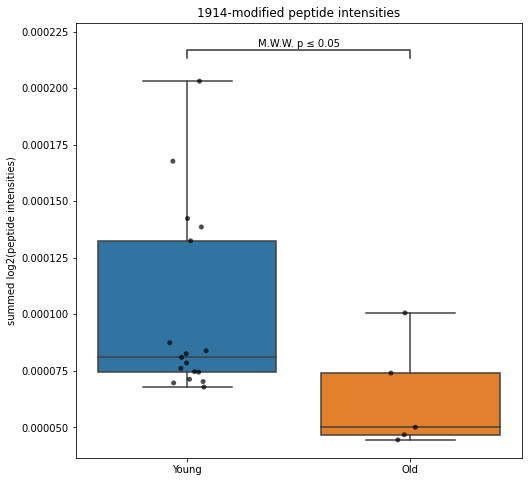

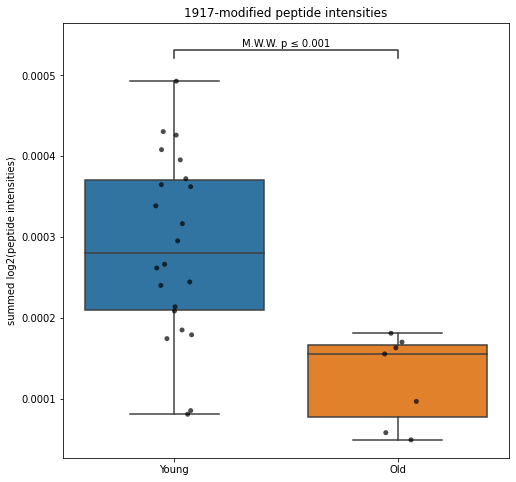

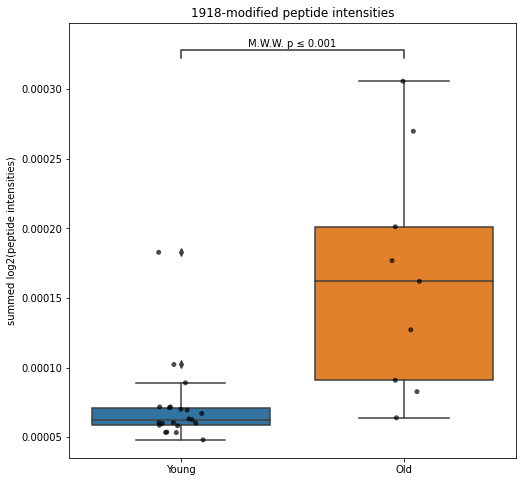

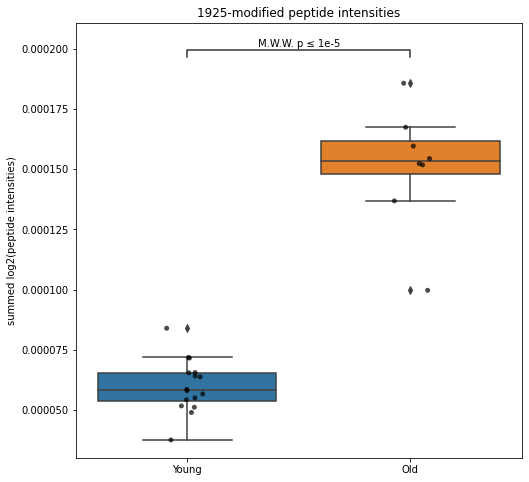

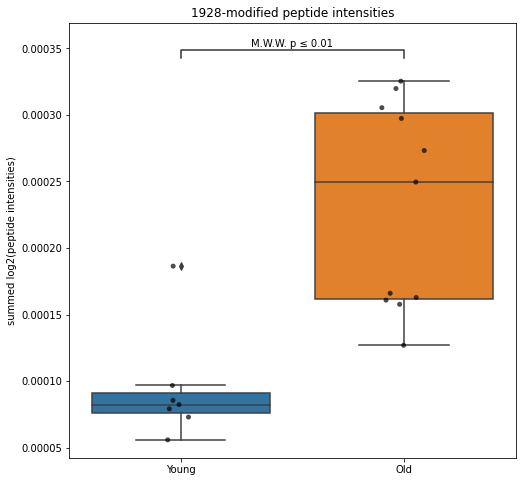

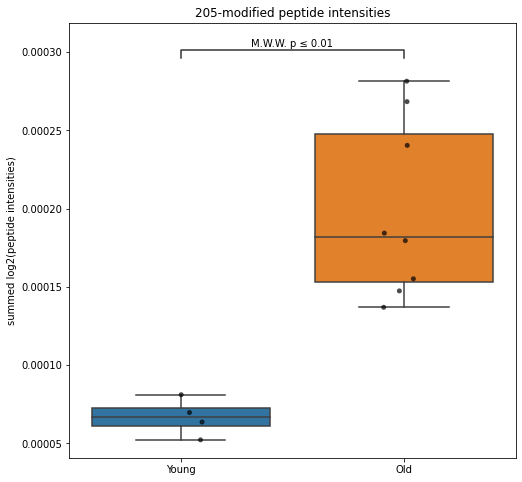

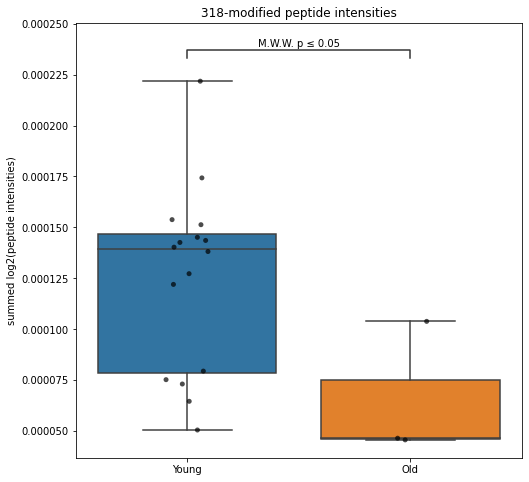

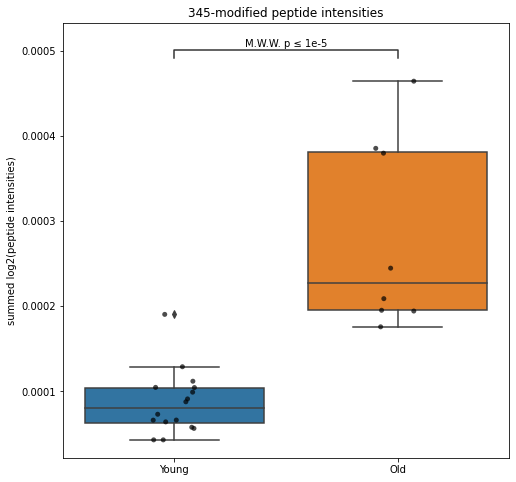

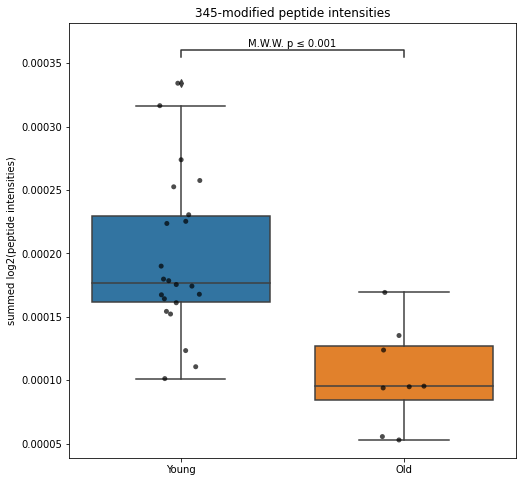

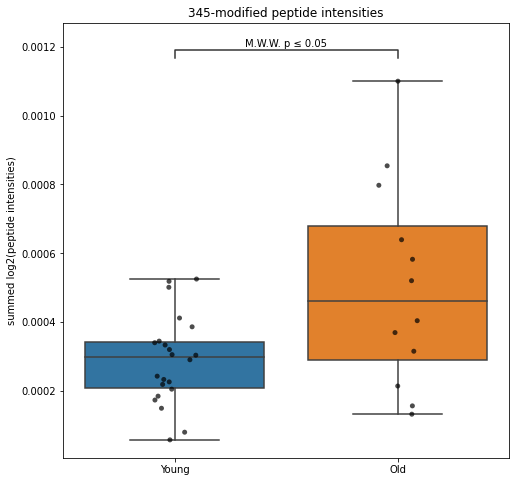

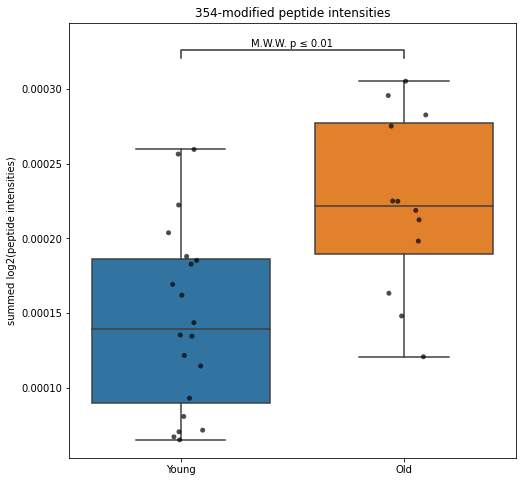

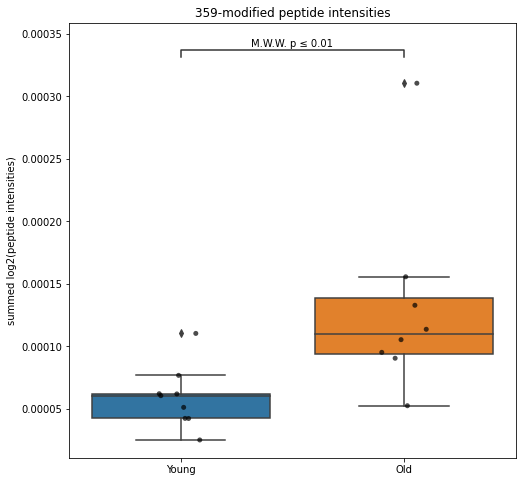

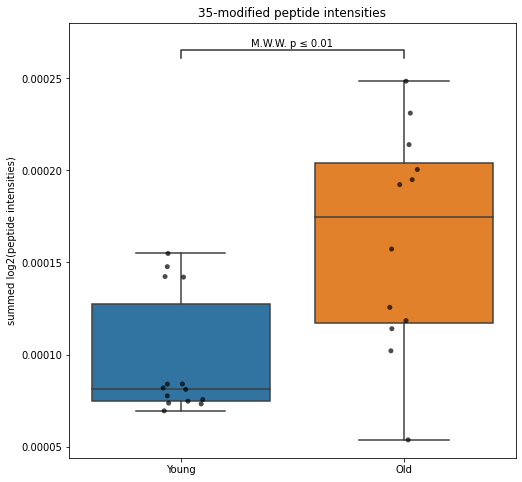

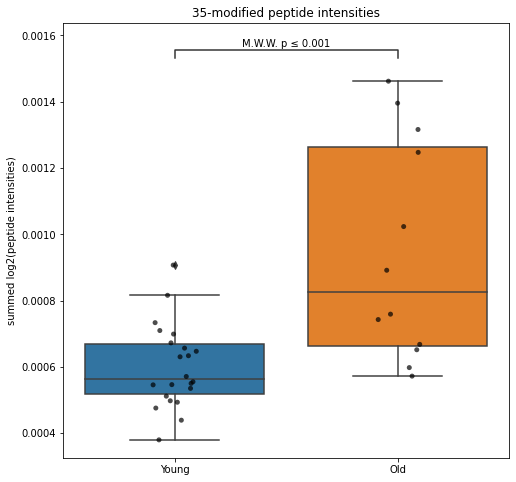

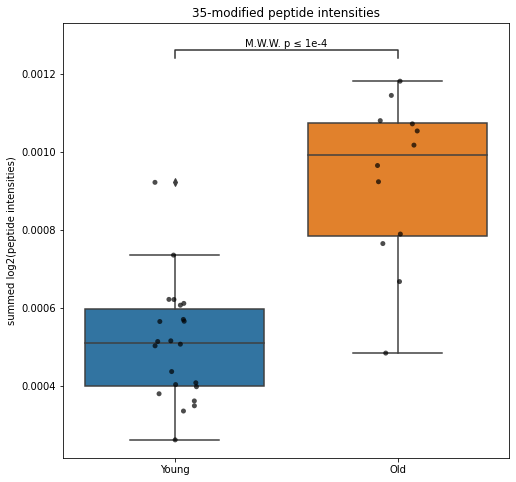

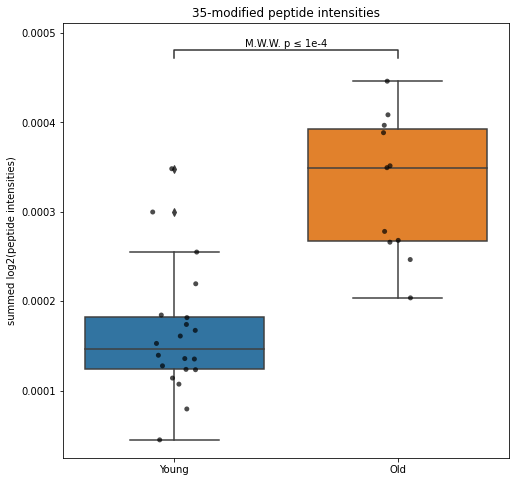

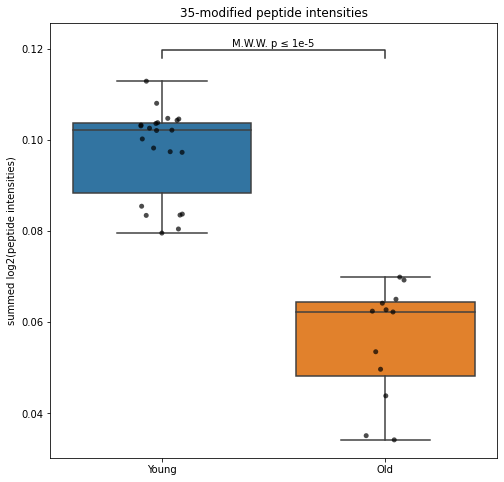

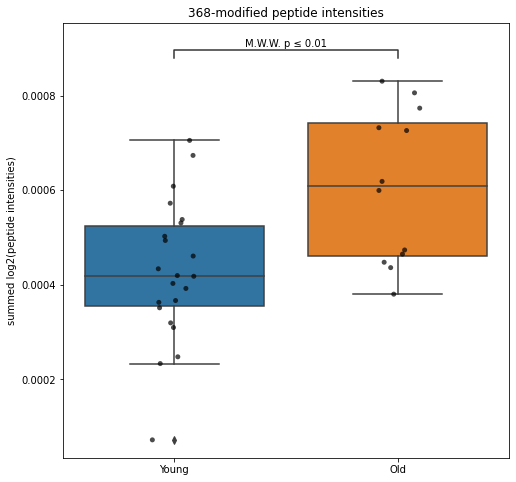

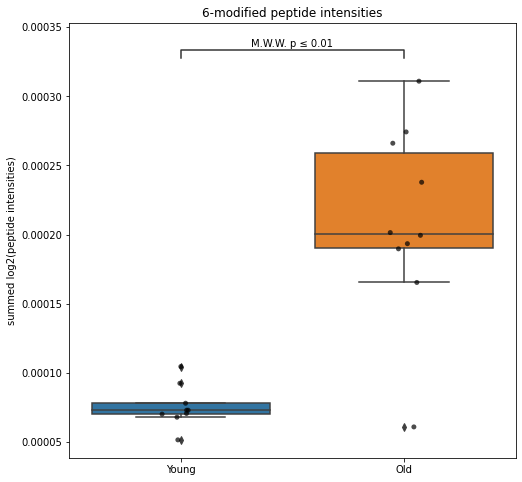

0: 0.03865724918356497 => 0.1261447078621594
1: 0.0003152270018836735 => 0.0027920105881125367
2: 0.0004926270009862024 => 0.0038178592576430686
3: 2.719345834166133e-06 => 8.429972085915012e-05
4: 0.0011940673705379587 => 0.007403217697335344
5: 0.00404040404040404 => 0.01926961926961927
6: 0.033023735810113516 => 0.12043950707217872
7: 5.438691668332266e-06 => 0.00011239962781220015
8: 0.00020810107766629506 => 0.002150377802551716
9: 0.038250879960103464 => 0.1261447078621594
10: 0.003294499897095937 => 0.01702158280166234
11: 0.005512134923899629 => 0.022783491018785133
12: 0.005927900834100707 => 0.02297061573214024
13: 0.0007530302153165608 => 0.0051875414832918635
14: 3.6865659808498135e-05 => 0.0005714177270317211
15: 6.773274595142255e-05 => 0.0008398860497976396
16: 2.148485851840218e-06 => 8.429972085915012e-05
17: 0.004670192363741602 => 0.020682280467998523
18: 0.0028804846690270907 => 0.016235459043607237


In [112]:
#Specific aanpassen, klopt niet voor nu
boxplots(Young,Oldrep, specific=False)

# Non-specific

In [118]:
Young["UnimodAccession"] = Young["Modifications"].apply(OA.get_unimod_acc)
Oldrep["UnimodAccession"] = Oldrep["Modifications"].apply(OA.get_unimod_acc)

In [119]:
YoungNS = Young.groupby("UnimodAccession").sum().reset_index()
OldNS = Oldrep.groupby("UnimodAccession").sum().reset_index()

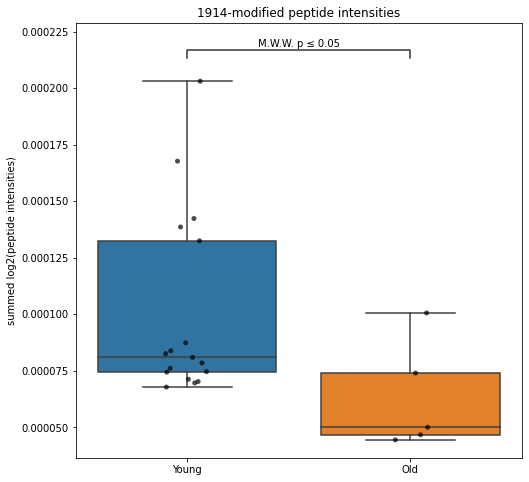

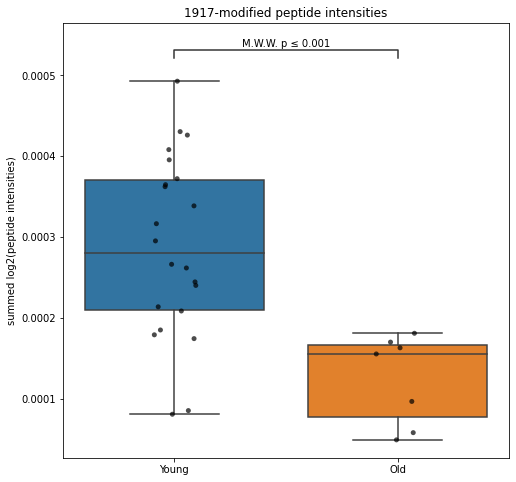

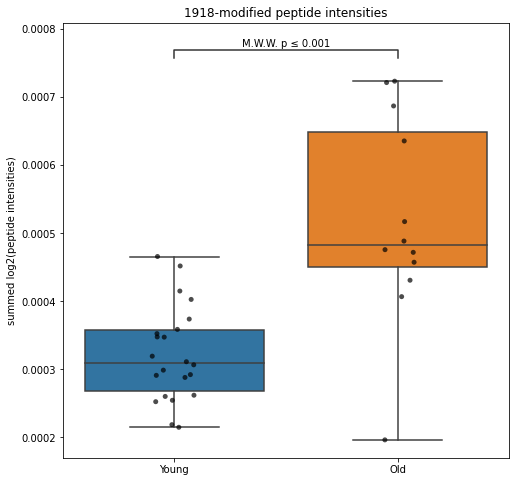

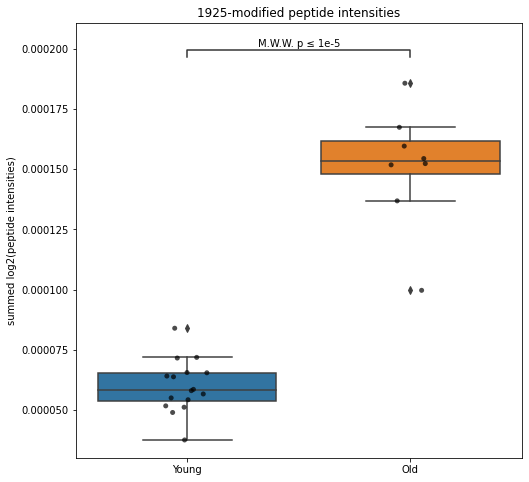

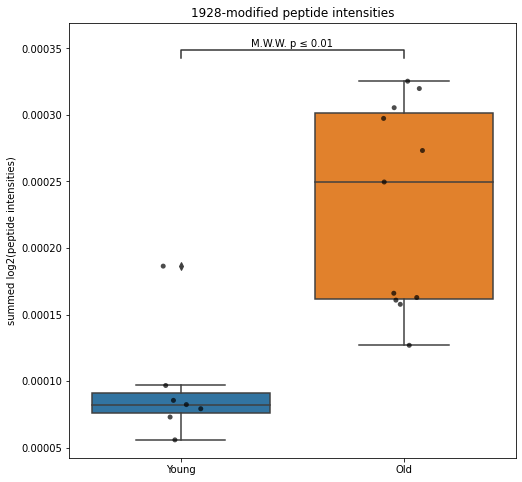

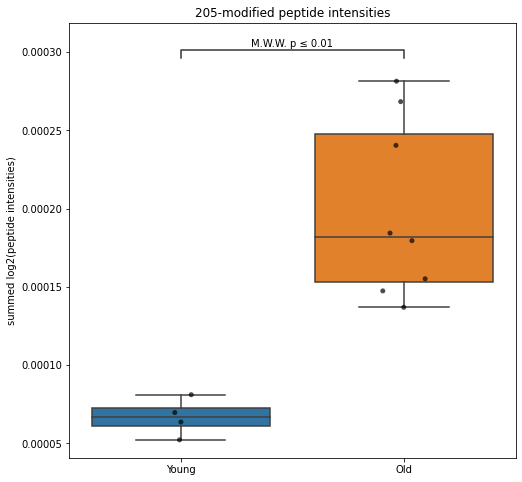

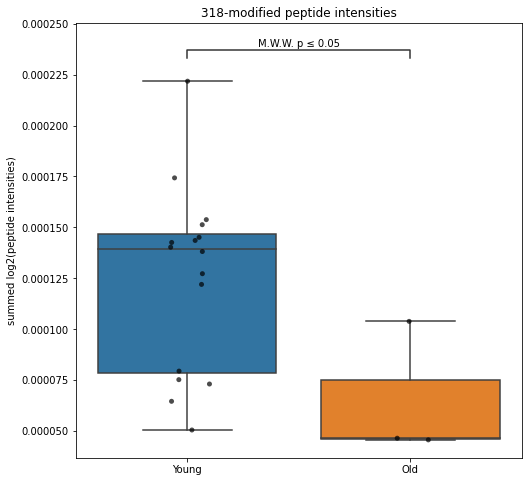

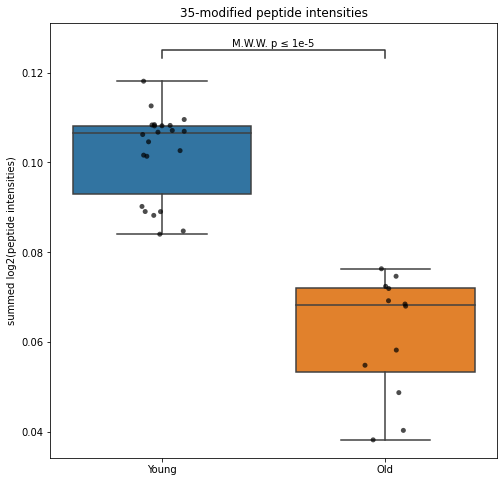

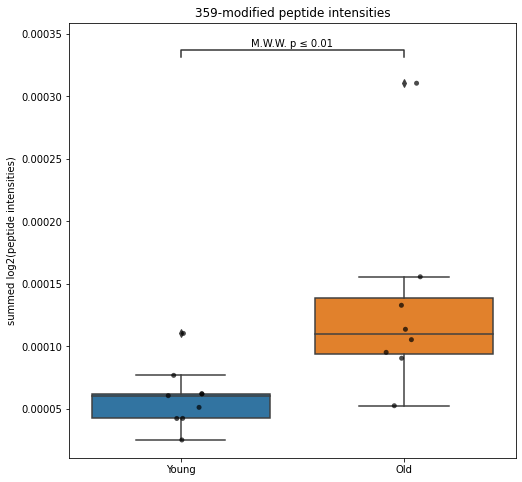

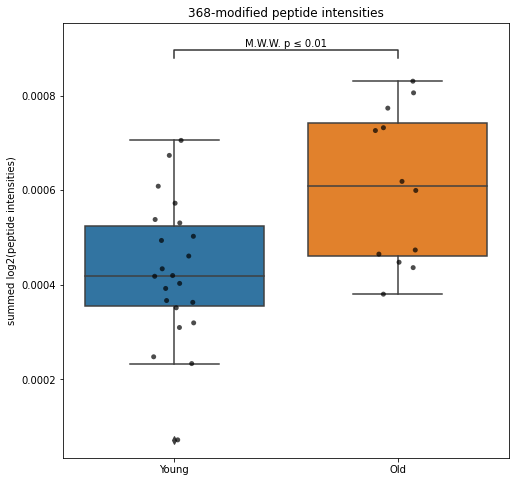

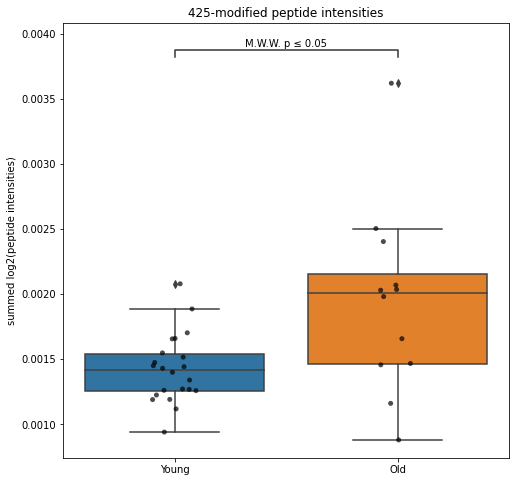

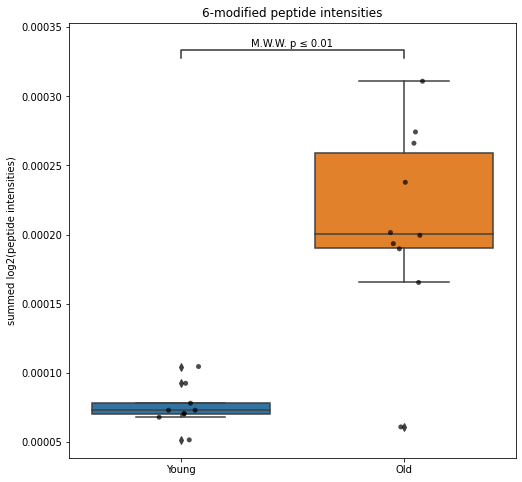

0: 0.03865724918356497 => 0.10308599782283993
1: 0.0003152270018836735 => 0.002521816015069388
2: 0.00019157015350537124 => 0.00204341497072396
3: 2.719345834166133e-06 => 4.3509533346658125e-05
4: 0.0011940673705379587 => 0.007642031171442935
5: 0.00404040404040404 => 0.01847041847041847
6: 0.033023735810113516 => 0.09606904962942114
7: 2.148485851840218e-06 => 4.3509533346658125e-05
8: 0.005512134923899629 => 0.019598701951643125
9: 0.004670192363741602 => 0.018680769454966408
10: 0.01825247593449743 => 0.058407922990391783
11: 0.0028804846690270907 => 0.015362584901477816


In [120]:
boxplots(Controldf=YoungNS, Treatmentdf=OldNS, specific=False)

# Log Fold Difference-Specific

In [121]:
Oldrep.set_index("Modifications", inplace=True)
Young.set_index("Modifications", inplace=True)

In [122]:
oldmodmed = Oldrep.median(axis=1).to_frame(name="Median").reset_index()

In [123]:
youngmodmed = Young.median(axis=1).to_frame(name="Median").reset_index()

In [124]:
data = pd.merge(left=youngmodmed, right=oldmodmed, on="Modifications", suffixes=["_young", "_old"]).set_index("Modifications")

In [125]:
data

,Median_young,Median_old
Modifications,,
[1384]Homocysteic_acid[M],0.000000,0.000000
[1914]Met->AspSA[M],0.000076,0.000000
[1915]Decarboxylation[D],0.000000,0.000000
[1915]Decarboxylation[E],0.000070,0.000000
[1916]Aspartylurea[H],0.000000,0.000000
...,...,...
[743]4-ONE+Delta:H(-2)O(-1)[H],0.000000,0.000000
[860]G-H1[R],0.000000,0.000000
[936]Chlorination[Y],0.000091,0.000113


In [126]:
import numpy as np
data = data.replace(0, np.nan)
data = data.dropna(how='any', axis=0)
datanozero = data.replace(np.nan, 0)

In [127]:
datanozero["FoldDiff"] = datanozero["Median_old"] / datanozero["Median_young"]

In [128]:
datanozero["LogFoldDiff"] = np.log2(datanozero["FoldDiff"])

In [129]:
datanozero["Old"] = datanozero["LogFoldDiff"]

In [130]:
datanozero["Young"] = 0

In [131]:
datanozero.reset_index(inplace=True)

In [132]:
datanozero

,Modifications,Median_young,Median_old,FoldDiff,LogFoldDiff,Old,Young
0,[1917]Formylasparagine[H],0.000295,0.000058,0.196455,-2.347730,-2.347730,0
1,[1918]Carbonyl[A],0.000063,0.000127,2.030855,1.022087,1.022087,0
2,[1918]Carbonyl[I],0.000154,0.000184,1.194971,0.256976,0.256976,0
3,[1918]Carbonyl[S],0.000070,0.000102,1.456269,0.542277,0.542277,0
4,[1922]Pro->HAVA[P],0.000441,0.000310,0.702911,-0.508585,-0.508585,0
5,[1925]Delta:O(4)[W],0.000055,0.000152,2.756832,1.463011,1.463011,0
6,[1927]Delta:H(4)C(5)O(1)[R],0.000070,0.000052,0.736324,-0.441588,-0.441588,0
7,[345]Trioxidation[C],0.000066,0.000195,2.953273,1.562315,1.562315,0
8,[345]Trioxidation[F],0.000178,0.000094,0.526116,-0.926548,-0.926548,0
9,[345]Trioxidation[W],0.000304,0.000520,1.712430,0.776045,0.776045,0


In [133]:
significant = [True,True,False,False,False,True,False,True,True,False,False,False,True,True,False, False, False, False,True,False,True,True,False,False,False,True,False,True,False,False,False,False,False,False, False,False,False,False]

In [134]:
len(significant)

38

In [135]:
datanozero["Significant"] = [True,True,False,False,False,True,False,True,True,False,False,False,True,True,False, False, False, False,True,False,True,True,False,False,False,False,False,True,False,True,False,False,False,False, False,False,False,False]

In [136]:
datanozero

,Modifications,Median_young,Median_old,FoldDiff,LogFoldDiff,Old,Young,Significant
0,[1917]Formylasparagine[H],0.000295,0.000058,0.196455,-2.347730,-2.347730,0,True
1,[1918]Carbonyl[A],0.000063,0.000127,2.030855,1.022087,1.022087,0,True
2,[1918]Carbonyl[I],0.000154,0.000184,1.194971,0.256976,0.256976,0,False
3,[1918]Carbonyl[S],0.000070,0.000102,1.456269,0.542277,0.542277,0,False
4,[1922]Pro->HAVA[P],0.000441,0.000310,0.702911,-0.508585,-0.508585,0,False
5,[1925]Delta:O(4)[W],0.000055,0.000152,2.756832,1.463011,1.463011,0,True
6,[1927]Delta:H(4)C(5)O(1)[R],0.000070,0.000052,0.736324,-0.441588,-0.441588,0,False
7,[345]Trioxidation[C],0.000066,0.000195,2.953273,1.562315,1.562315,0,True
8,[345]Trioxidation[F],0.000178,0.000094,0.526116,-0.926548,-0.926548,0,True
9,[345]Trioxidation[W],0.000304,0.000520,1.712430,0.776045,0.776045,0,False


In [137]:
Significant = datanozero[datanozero["Significant"] == True]

In [138]:
Significant

,Modifications,Median_young,Median_old,FoldDiff,LogFoldDiff,Old,Young,Significant
0,[1917]Formylasparagine[H],0.000295,0.000058,0.196455,-2.347730,-2.347730,0,True
1,[1918]Carbonyl[A],0.000063,0.000127,2.030855,1.022087,1.022087,0,True
5,[1925]Delta:O(4)[W],0.000055,0.000152,2.756832,1.463011,1.463011,0,True
7,[345]Trioxidation[C],0.000066,0.000195,2.953273,1.562315,1.562315,0,True
8,[345]Trioxidation[F],0.000178,0.000094,0.526116,-0.926548,-0.926548,0,True
12,[354]Nitro[Y],0.000135,0.000225,1.661331,0.732339,0.732339,0,True
13,[35]Oxidation[C],0.000075,0.000192,2.575524,1.364866,1.364866,0,True
18,[35]Oxidation[I],0.000571,0.000891,1.561146,0.642606,0.642606,0,True
20,[35]Oxidation[P],0.000514,0.001018,1.980324,0.985737,0.985737,0,True
21,[35]Oxidation[Q],0.000139,0.000349,2.503808,1.324124,1.324124,0,True


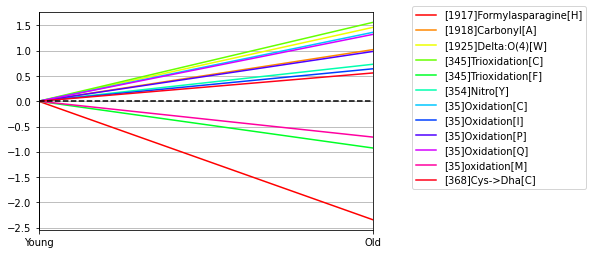

In [139]:
fig, axes = plt.subplots()
pd.plotting.parallel_coordinates(Significant, "Modifications", ["Young","Old"], colormap="hsv")
axes.legend(bbox_to_anchor=(1.1, 1.05))
plt.hlines(y=0,xmin="Young", xmax="Old", colors="Black", linestyles="dashed")
